In [1]:
import time
import cv2
import os
import numpy as np 
import matplotlib.pyplot as plt
import random
import math

# Exponential Smoothing

With human movements, noise typically forms high frequen- cies in the signal while actual limb movements have lower frequencies. A low-pass filter is designed to let these desired low frequency portions pass through, while attenuating high frequency signals above a fixed cutoff frequency. The order of a low-pass filter relates to how aggressively it attenuates each frequency: first order filters reduce the signal amplitude by half every time the frequency doubles, while higher order variants reduce the signal amplitude at a greater rate. A dis- crete time realization of a first order low-pass filter is given by Equation 1 where Xi and Xˆi denote the raw and filtered data at time i and α is a smoothing factor in ]0, 1]:

$$ {\hat{X}}_i = \alpha X_i + (1 - \alpha) \hat{X}_{i-1}   $$

The first term of the equation is the contribution of new in- put data value, and the second term adds inertia from pre- vious values. As α decreases, jitter is reduced, but lag in- creases since the output responds more slowly to changes in input. Since the contribution of older values exponentially decreases, a low-pass filter will have less lag than a high n moving average filter.

In [2]:
seq = [(x-50)**2 for x in range(100)]

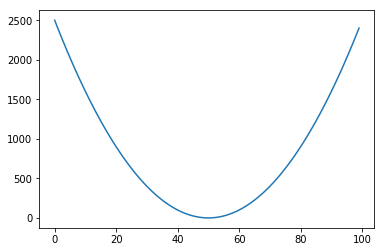

In [3]:
plt.plot(seq)

In [16]:
step = 200
jitterd_seq = [ x + step * (random.random()-0.5) for x in seq]

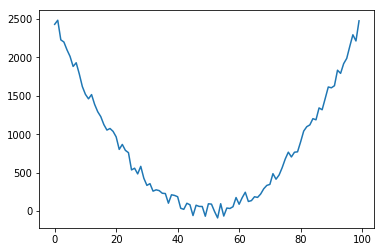

In [17]:
plt.plot(jitterd_seq)

In [30]:
class Exp_filter():
    def __init__(self):
        self.last_output = None
        
    def push(self, data, alpha):
        if self.last_output != None:
            self.last_output = alpha * data + (1 - alpha) * self.last_output
        else:
            self.last_output = data
        return self.last_output

In [33]:
ef = Exp_filter()
filtered_seq = [ ef.push(x,0.2) for x in jitterd_seq]

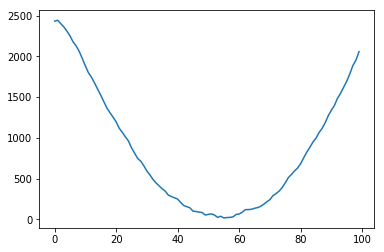

In [34]:
plt.plot(filtered_seq)

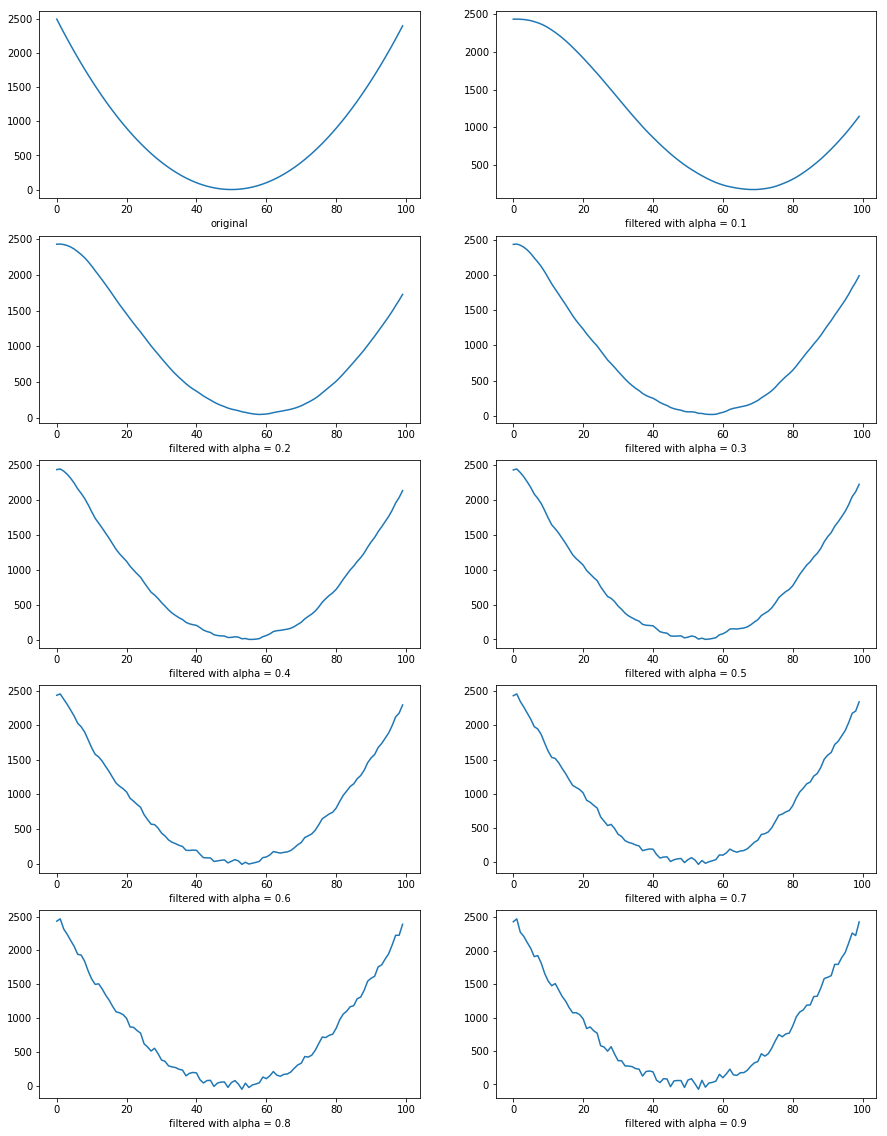

In [37]:
plt.figure(figsize = (15,20))
count = 1
als = [x/10 for x in range(10)]
for i in range(10):
    plt.subplot(5,2,count)
    count += 1
    if(i == 0):
        plt.plot(seq)
        plt.xlabel("original")
    else:
        ef1 = Exp_filter()
        ef2 = Exp_filter()
        fseq = [ef2.push(ef1.push(x,als[i]),als[i]) for x in jitterd_seq]
        plt.plot(fseq)
        plt.xlabel("filtered with alpha = " + str(als[i]))

# 1 Euro Filter

The 1e filter is an adaptive first-order low-pass filter: it adapts the cutoff frequency of a low-pass filter for each new sample according to an estimate of the signal’s speed, or more generally, its derivative value. Even though noisy signals are often sampled at a fixed frequency, filtering can not always follow the same pace, especially in event-driven systems. To accommodate possible fluctuations, we rewrite equation 1 to take into account the actual time interval between samples. Using a direct analogy with an electrical circuit, where a resistor in series with a capacitor defines a first order low-pass filter, α can be computed as a function of the sampling period Te and a time constant τ, both expressed in seconds (Equation 4). The resistor and capacitor values define the time constant $(τ = RC)$ and the corresponding cutoff frequency fc, in Hertz, of the circuit (Equation 5). 

$$ \alpha = \frac{1}{1 + \frac{\tau}{T_e} }  $$

$$ \tau = \frac{1}{2 \pi f_c} $$

$$ \hat{X_i} = (X_i + \frac{\tau}{T_e} \hat{X}_{i-1}) \frac{1}{1 + \frac{\tau}{T_e}} $$

$$ f_c = f_{c_{min}} + \beta \left| {\dot{\hat{X}}_{i}} \right|$$

The sampling period Te (or its inverse, the sampling rate) can be automatically computed from timestamps, so the cut-off frequency fc is the only configurable parameter in equation 6. As with any low-pass filter, decreasing fc reduces jitter, but increases lag. Finding a good trade-off between the two is difficult since people are more sensitive to jitter at low speeds, and more sensitive to lag at high speeds. This is why an adaptive cutoff frequency works well. To reduce jitter, a low fc is used at low signal speeds, and to reduce lag, fc is increased as speed increases. We found that a straight-forward linear relationship between cutoff frequency fc and the absolute speed works well (Equation 7). The speed (i.e the derivative $ \dot{\hat{X}}_i$ ) is computed from raw signal values using the sampling rate and then low-pass filtered with a cutoff fre- quency chosen to avoid high derivative bursts caused by jit- ter. Our implementation uses a fixed value of 1 Hz, leaving only two configurable parameters: the intercept fcmin and the slope β shown in Equation 7. Details of the algorithm are provided in the Appendix.

## caculating $\alpha$

$$ \alpha = \frac{1}{1 + \frac{\tau}{T_e} }  $$

In [39]:
def alpha(rate, cutoff):
    tau = 1.0 / (2 * math.pi * cutoff)
    te = 1.0 / rate
    return 1.0 / (1.0 + tau / te)

## Caculating $f_c$

$$ f_c = f_{c_{min}} + \beta \left| {\dot{\hat{X}}_{i}} \right|$$

In [66]:
current_min_cutoff = 0.03
current_beta = 0
def get_cutoff(edx):
    return current_min_cutoff + current_beta * abs(edx)

## Implementing 1 Euro Filter

In [67]:
class Euro_filter():
    def __init__(self, cutoff_limit, _beta):
        self.min_cutoff = cutoff_limit
        self.beta = beta
        self.dcutoff = 1
        
        self.xfilt = Exp_filter()
        self.dxfilt = Exp_filter()
        
        self.dx = 0
        self.first_time = True
    
    def push(self, data, rate):
        if self.first_time:
            self.first_time = False
            self.dx = 0
        else:
            self.dx = (data - self.xfilt.last_output) * rate
        edx = self.dxfilt.push(self.dx, alpha(rate, self.dcutoff))
        
#         cutoff = self.min_cutoff + self.beta * abs(edx)
        cutoff = get_cutoff(edx)
        
        return self.xfilt.push(data, alpha(rate, cutoff))

In [68]:
min_cutoff = 0.03
beta = 0
ef = Euro_filter(min_cutoff, beta)
filtered_seq = [ ef.push(x,1) for x in jitterd_seq]

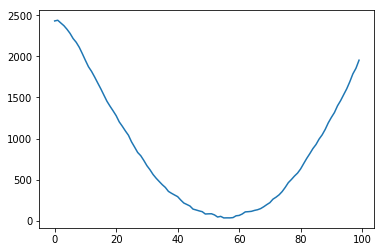

In [69]:
plt.plot(filtered_seq)